# *IT00CS34 Edge Computing for ML - Spring 25*



# Training using TensorFlow

## Overview

To effectively deploy deep neural models on resource-constrained edge devices, two critical aspects of model optimization are most useful: pruning, which involves reducing the size of a neural network by eliminating unnecessary parameters, and quantization, which involves reducing the precision of numerical values in the model to conserve memory and computational resources.

For using these techniques, we define the application area by employing a small CNN based-architecture trained on rock-paper-scissors dataset by Laurence Moroney. At the end of the notebook, we obtain the trained full-precision model to be used for the further steps of the project.

### Dataset overview
Rock Paper Scissors contains images from a variety of different hands, from different races, ages and genders, posed into Rock / Paper or Scissors and labelled as such. These images have all been generated using CGI techniques as an experiment in determining if a CGI-based dataset can be used for classification against real images.

Note that all of this data is posed against a white background.

Each image is 300×300 pixels in 24-bit color

## Setup

You may need to restart session in google colab after executing the following cell.

In [ ]:
! pip install --upgrade --force-reinstall pandas

In [ ]:
! pip install -q tensorflow-model-optimization

In [1]:
import os
import tensorflow as tf
from tensorflow_model_optimization.python.core.keras.compat import keras
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
tf.random.set_seed(
    seed=81
)

## Using Tensorflow Datasets API to load MNIST

TFDS datasets often come with data already split into different sets. For rock_paper_scissors, it has splits for train and test. We use the [Slicing API](https://www.tensorflow.org/datasets/splits#slicing_api) for TFDS to create a validation split.

Next, we aim to understand how the dataset is formatted and utilize visualizations. Finally, the dataset is preprocessed before being passed to the model. For preprocessing, we rescale to a much smaller resolution, convert to grayscale and normalize the image values as float32 within the range [0, 1] for all three splits.

In [ ]:
(dataset_train, dataset_val, dataset_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Input image shape: (300, 300, 3)
Image type: <dtype: 'uint8'>
Label shape: ()
Label type: <dtype: 'int64'>


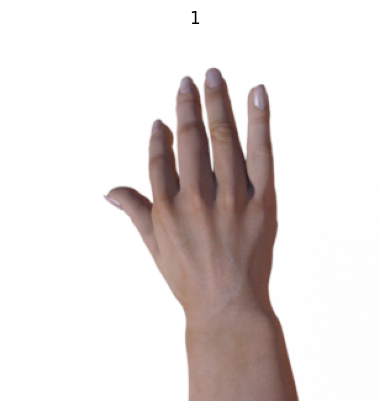

In [3]:
ds = dataset_train.take(1)  # Only take a single example
for example in ds:  # example is `('image': tf.Tensor, 'label': tf.Tensor)`
  image = example[0]
  label = example[1]
  print(f"Input image shape: {image.shape}\nImage type: {image.dtype}")
  print(f"Label shape: {label.shape}\nLabel type: {label.dtype}")
  plt.imshow(image, cmap='gray')
  plt.title(label.numpy())
  plt.axis("off")
  plt.show()


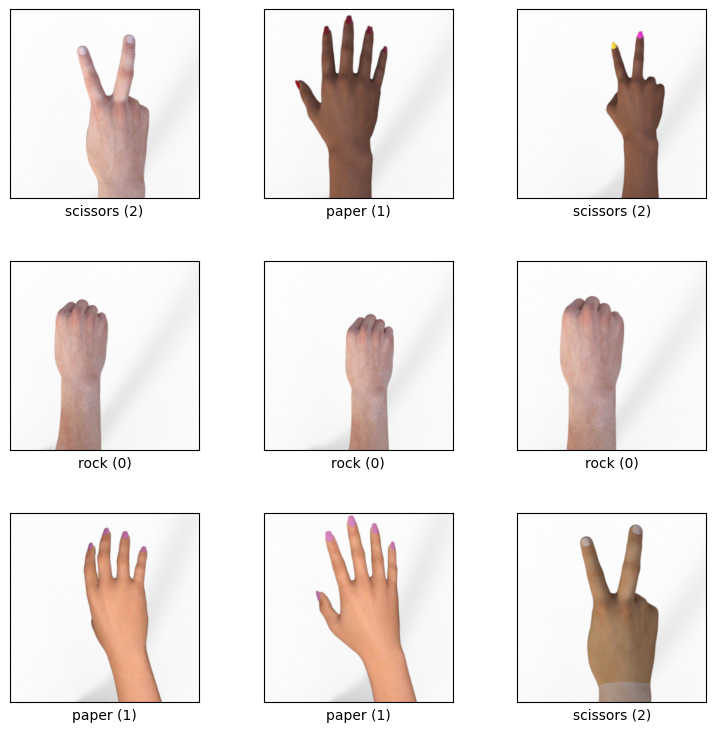

In [4]:
fig = tfds.show_examples(dataset_test, ds_info)

### Parameters

In [5]:
batch_size = 32
n_epochs = 8

### Preprocessing

In [9]:
# Preprocessing function
def preprocess(image, label):
  """applies the target preprocessing to the image and returns preprocessed image with label."""
  image = tf.image.resize(image, (32, 32))  # Resize images
  image = tf.image.rgb_to_grayscale(image)    # Convert to grayscale
  image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values
  return image, label


In [10]:
dataset_train = (dataset_train
                 .map(preprocess)
                 .shuffle(1000)
                 .batch(batch_size)
                 .prefetch(tf.data.AUTOTUNE))

dataset_val = (dataset_val
                .map(preprocess)
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE))

dataset_test = (dataset_test
                .map(preprocess)
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE))

## Training Neural Network

In [ ]:
# Define the model architecture.
model = keras.Sequential([
    keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(16, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=n_epochs
)


In [ ]:
test_loss, baseline_accuracy = model.evaluate(
    dataset_test, verbose=0)

print(f'Test loss: {test_loss:.4f}')
print('Baseline test accuracy:', baseline_accuracy)

In [ ]:
# Saving the model in .h5 format
keras.models.save_model(model, './Full_Precision_RPS.h5', include_optimizer=False)


In this notebook, we trained a convolutional neural network on the rock-paper-scissors dataset using TensorFlow (and various of its APIs). It's important to note the size of the trained model in terms of the number of trainable parameters and the baseline test accuracy for further comparisons during the pruning and quantization steps.

## Pruning
Experiment with different pruning methods available in tensorflow_model_optimization library and track the test set accuracy and model size.

### Task 1A: apply PolynomialDecay Pruning Schedule on the whole model.

### Task 1B: apply layerwise pruning only to the conv2D layers.

For both tasks try different sparsity parameters.

## Quantization
Quantization helps reduce the size and computation requirements of models, making them more efficient, especially for deployment on resource-constrained devices. Here, we only experiment with post-training quantization methods.

The following post-training quantization can be applied to both the base model and the pruned model. Note: all the following tasks will produce different versions of the same model.

### Task 2A: Dynamic Range Quantization

### Task 2B: Integer quantization of model parameters with float input/outputs (needs representative dataset)

### Task 2C: Full integer quantization (needs representative dataset)

Verify each case with the following code:

In [ ]:
interpreter = tf.lite.Interpreter(model_path="path/to/model.tflite")
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input type:", input_details[0]['dtype'])
print("Output type:", output_details[0]['dtype'])

## Converting to tflite

Run the following bash command to convert the `your_model.tflite` to arduino (`C`) compatible format, a header file (`model.h`). Save the model for future use.

*Note: Remember to fix the paths.*

In [ ]:
!echo "const unsigned char model[] = {" > /path/to/model.h
!cat path/to/model.tflite | xxd -i      >> /path/to/model.h
!echo "};"                              >> /path/to/model.h

You can check the file size of the final model header by executing the following code.

In [ ]:
import os
model_h_size = os.path.getsize("/path/to/model.h") # Fix the path
print(f"Header file, model.h, is {model_h_size:,} bytes.")